# Cerinta 1 - Reprezentarea modelului de clasificare

In [1]:
from copy import deepcopy
from functools import reduce
from json import dumps
from math import inf, log
import matplotlib.pyplot as plt
from operator import add
from os import listdir
from random import shuffle

from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy import load

download('wordnet')
download('stopwords')

[nltk_data] Downloading package wordnet to /home/teo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/teo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class NewsClassificationModel:
	def __init__(self, stop_words_file):
		self._ALPHA = 1
		self._chars_to_remove = '012345679.,-~`|\\/:;\'"?![]()\n\"'
		self.class_words = {}
		self.class_app = {}
		self.total_words = {}
		self.total_files = 0
		self.stop_pos = {'PART', 'DET', 'PUNCT', 'AUX'}

		self.wnl = WordNetLemmatizer()
		self.nlp = load('en')

		self.stop_words = set(stopwords.words('english')) | set(' ')
		with open(stop_words_file) as f:
			self.stop_words.union(set(token.replace('\n', '') for token in f))


	def _remove_chars(self, s):
		for ch in self._chars_to_remove:
			s = s.replace(ch, '')

		return s


	def _should_keep_token(self, tok, elim_stops, lemmatise):
		if elim_stops:
			if lemmatise:
				return (tok.lemma_ not in self.stop_words
					and tok.pos_ not in self.stop_pos
					and not tok.is_stop)
			else:
				return tok not in self.stop_words

		return True


	def _parse_file(self, file, elim_stops, lemmatise):
		lems = []
		# TODO: fa mai functional
		with open(file, encoding='utf8') as f:
			if lemmatise:
				tokens = self.nlp(f.read().replace('\n', ' '))
			else:
				tokens = f.read().replace('\n', ' ').split()

			for tok in tokens:
				if self._should_keep_token(tok, elim_stops, lemmatise):
					if lemmatise:
						lem = self.wnl.lemmatize(
							self._remove_chars(tok.lemma_).lower()
						)
					else:
						lem = tok

					if lem and lem not in self.stop_words:
						lems.append(lem)


		return lems


	def add_file(self, file, clss, elim_stops, lemmatise):
		self.total_files += 1

		if clss in self.class_app:
			self.class_app[clss] += 1
		else:
			self.class_app[clss] = 1
			self.class_words[clss] = {}
			self.total_words[clss] = 0

		for lem in self._parse_file(file, elim_stops, lemmatise):
			self.total_words[clss] += 1

			if lem in self.class_words[clss]:
				self.class_words[clss][lem] += 1
			else:
				self.class_words[clss][lem] = 1


	def _compute_log_prob(self, word, cl):
		return log(
			(self.class_words[cl].get(word, 0) + self._ALPHA)
			/ (self.total_words[cl] + len(self.class_words) * self._ALPHA)
		)


	def run_inference(self, file, elim_stops, lemmatise):
		max_prob = -inf
		# TODO: incearca fara list()
		lems = self._parse_file(file, elim_stops, lemmatise)

		for cl in self.class_words:
			cl_prob = reduce(
				add,
				map(lambda l: self._compute_log_prob(l, cl), lems),
				0
			) + log(self.class_app[cl] / self.total_files)

			if max_prob < cl_prob:
				max_prob = cl_prob
				pred = cl
		
		return pred

	def print(self, file):
		with open(file, 'w') as f:
			f.write("class_app:\n")
			f.write(dumps(self.class_app, indent=4) + '\n')
			f.write("class_words:\n")
			f.write(dumps(self.class_words, indent=4) + '\n')

In [3]:
def _get_train_test_files(path, stop_words_file, elim_stops, lemmatise):
    train_files = []
    test_files = []

    for clss in listdir(path):
        files_in_class = list(map(
            lambda f: f'{path}/{clss}/{f}',
            listdir(f'{path}/{clss}')
        ))
        shuffle(files_in_class)
        
        num_files = len(files_in_class)
        num_tests = int(num_files / 4)
    
        test_files += list(zip(
            [clss] * num_tests,
            files_in_class[:num_tests]
        ))
        train_files += list(zip(
            [clss] * (num_files - num_tests),
            files_in_class[num_tests:]
        ))
    
    shuffle(train_files)
    return train_files, test_files, listdir(path)


def _run_tests(model, test_files, classes, elim_stops, lemmatise):
    precs = {}
    recalls = {}
    total_preds = {}

    preds = list(map(
        lambda t: (t[0], model.run_inference(t[1], elim_stops, lemmatise)),
        test_files
    ))

    for clss in classes:
        correct_preds = len(list(filter(
            lambda p: clss == p[1] and p[0] == p[1],
            preds
        )))
        files_class = len(list(filter(lambda p: clss == p[0], preds)))
        preds_class = len(list(filter(lambda p: clss == p[1], preds)))

        precs[clss] = correct_preds / preds_class
        recalls[clss] = correct_preds / files_class
    
    return recalls, precs


def _plot_results(xs, precs, recalls):
    for clss in precs:
        plt.figure(figsize=(23,5))
        plt.plot(xs, precs[clss], label='Precision')
        plt.plot(xs, recalls[clss], label='Recall')
        plt.xlabel('File index', fontsize=15)
        plt.ylabel('Percentage', fontsize=15)
        plt.legend(fontsize=15)
        plt.title(f'Precision and Recall for Class "{clss}"', fontsize=15)
        plt.show()


def train_and_test(path, stop_words_file, elim_stops, lemmatise):
    model = NewsClassificationModel(stop_words_file)
    train_files, test_files, classes = _get_train_test_files(
        path,
        stop_words_file,
        elim_stops,
        lemmatise
    )

    precs = {clss: [] for clss in classes}
    recalls = deepcopy(precs)
    xs = []
    i = 1

    for clss, file in train_files:
        if i % 100 == 0:
            xs.append(i)
            rec, prec = _run_tests(model, test_files, classes, elim_stops, lemmatise)
            for cl in classes:
                recalls[cl].append(rec[cl])
                precs[cl].append(prec[cl])

        model.add_file(file, clss, elim_stops, lemmatise)
        i += 1
    
    xs.append(i)
    rec, prec = _run_tests(model, test_files, classes, elim_stops, lemmatise)
    for cl in classes:
        recalls[cl].append(rec[cl])
        precs[cl].append(prec[cl])

    _plot_results(xs, precs, recalls)

Testing classification: ELIMINATION + LEMMATISATION...


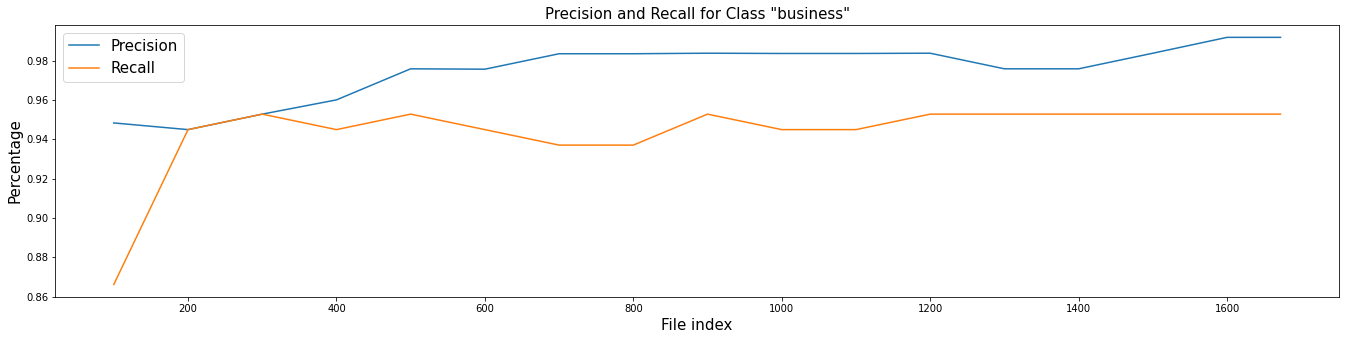

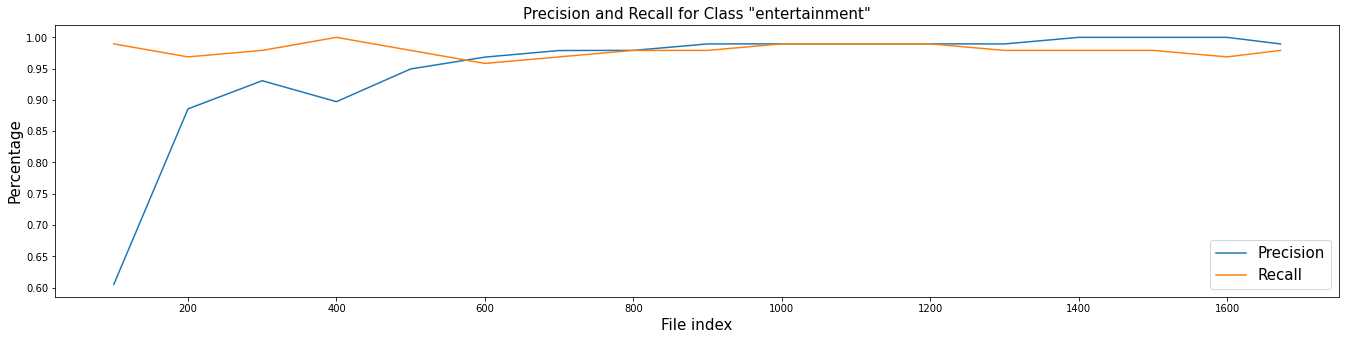

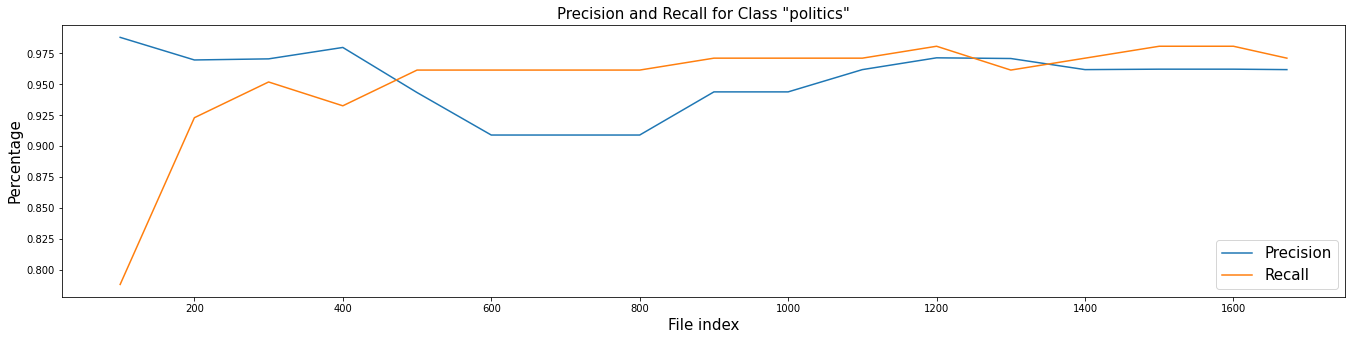

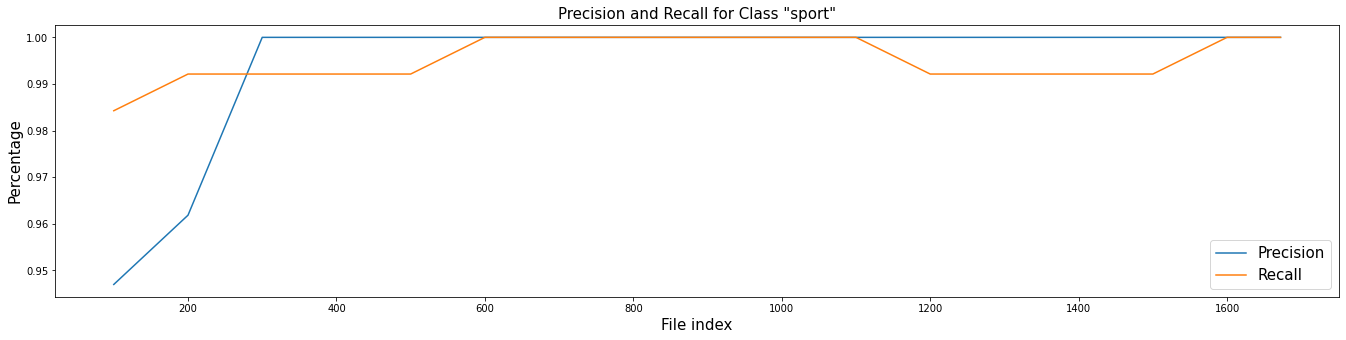

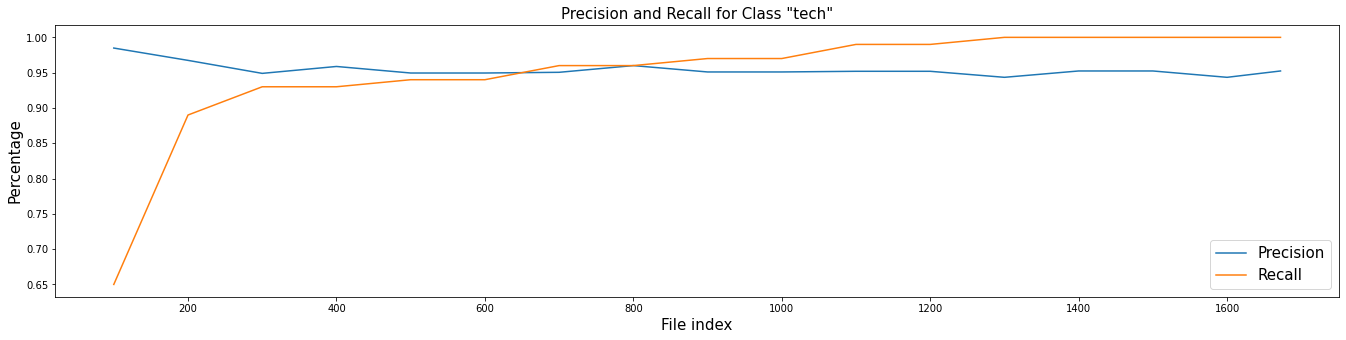


Testing classification: NO ELIMINATION + LEMMATISATION...


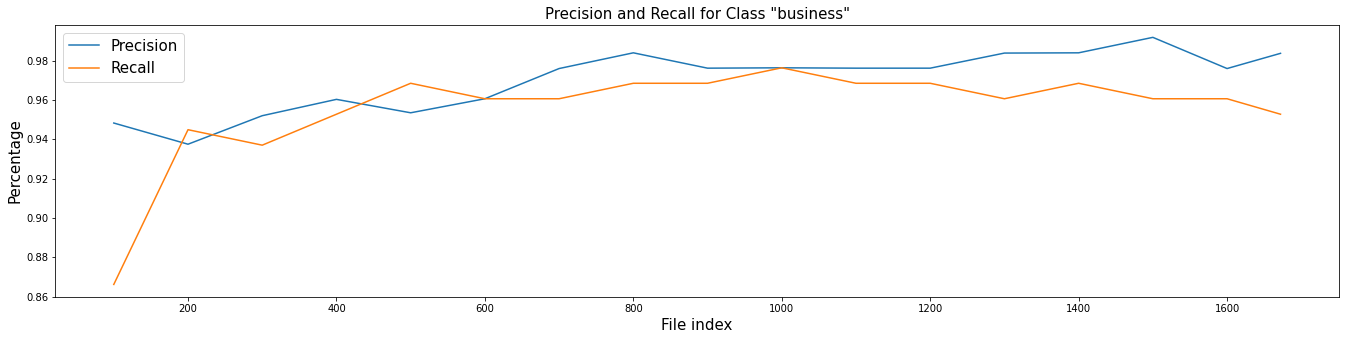

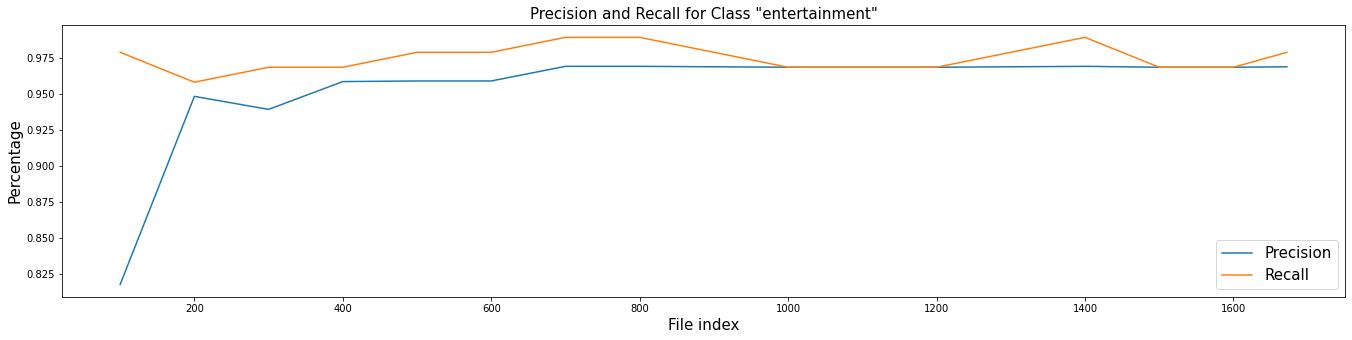

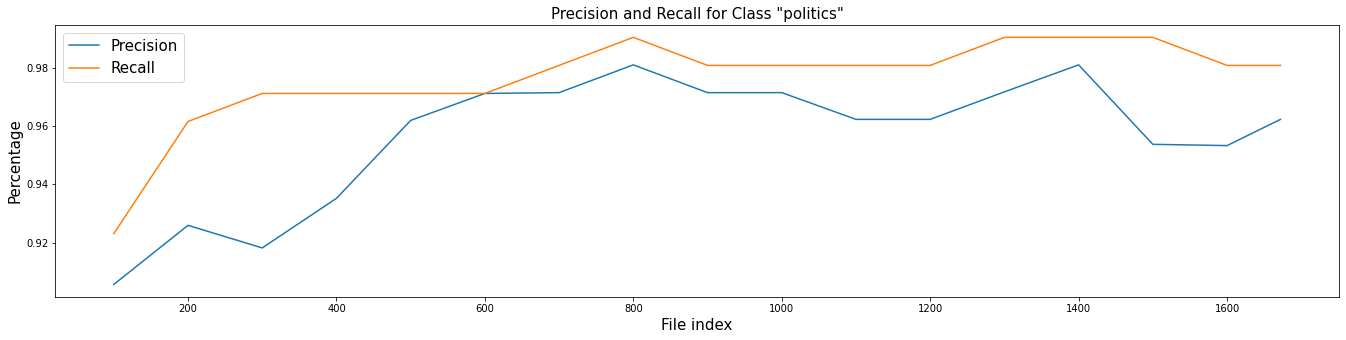

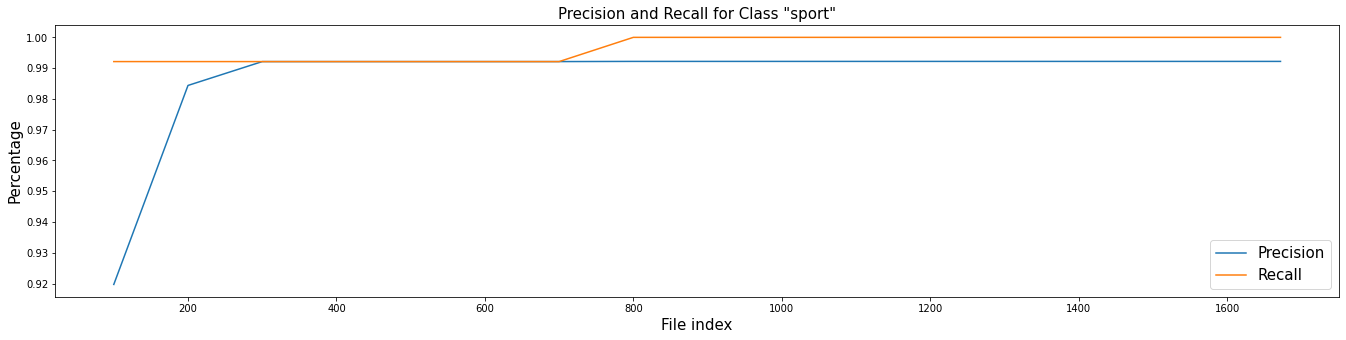

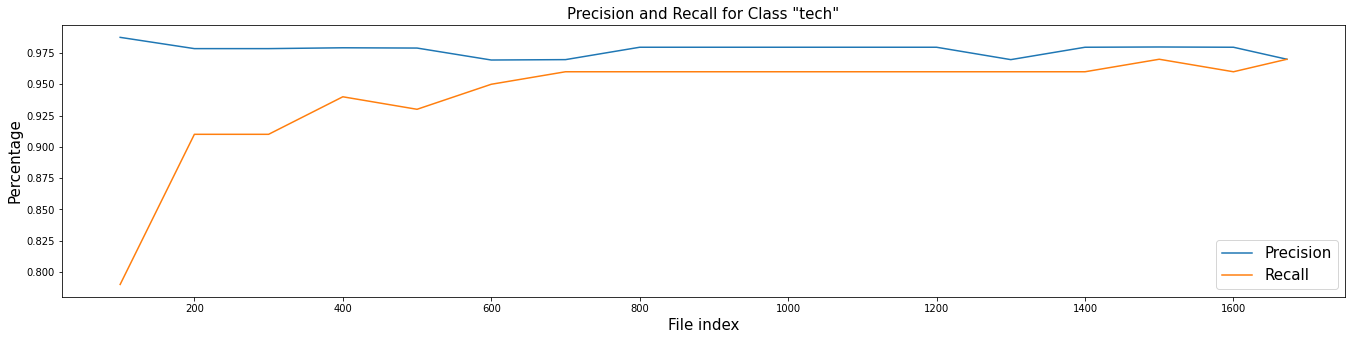


Testing classification: ELIMINATION + NO LEMMATISATION...


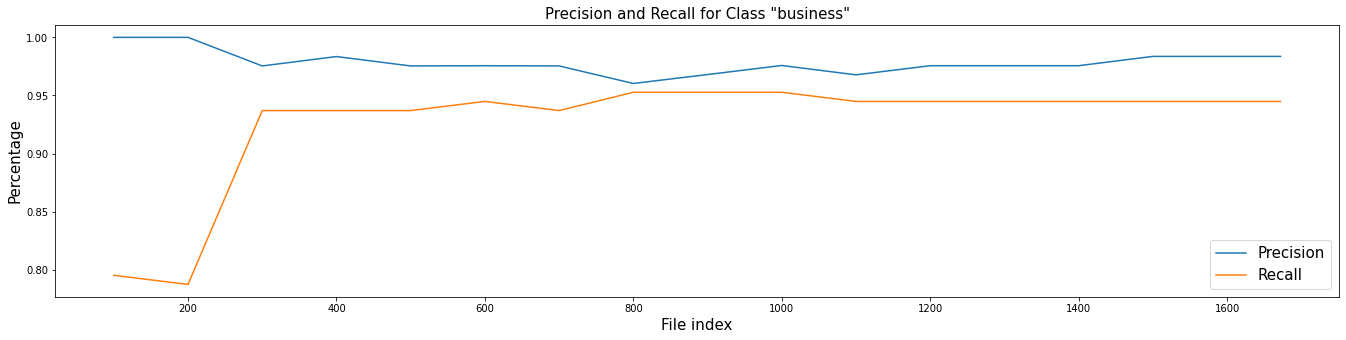

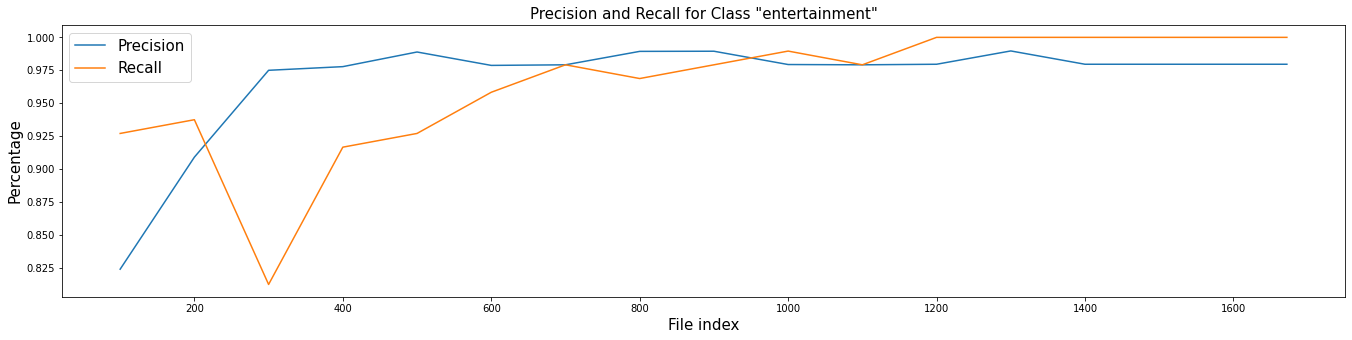

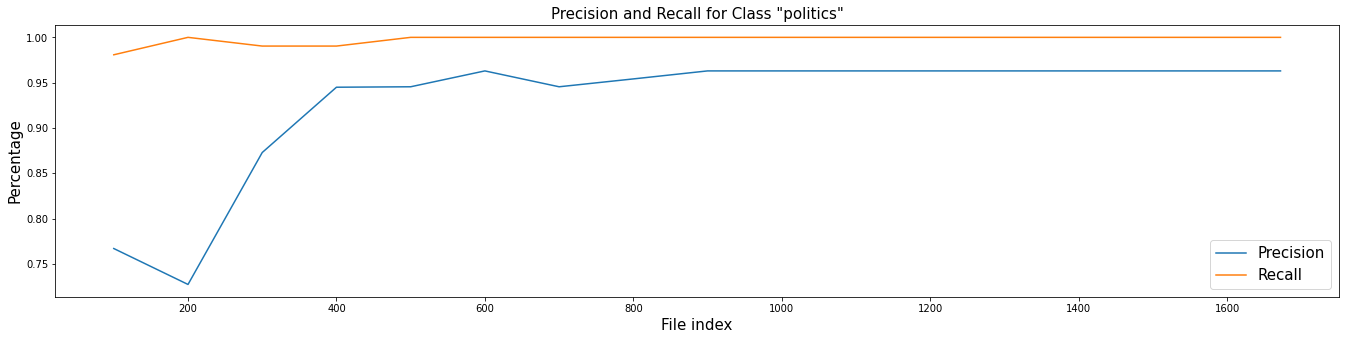

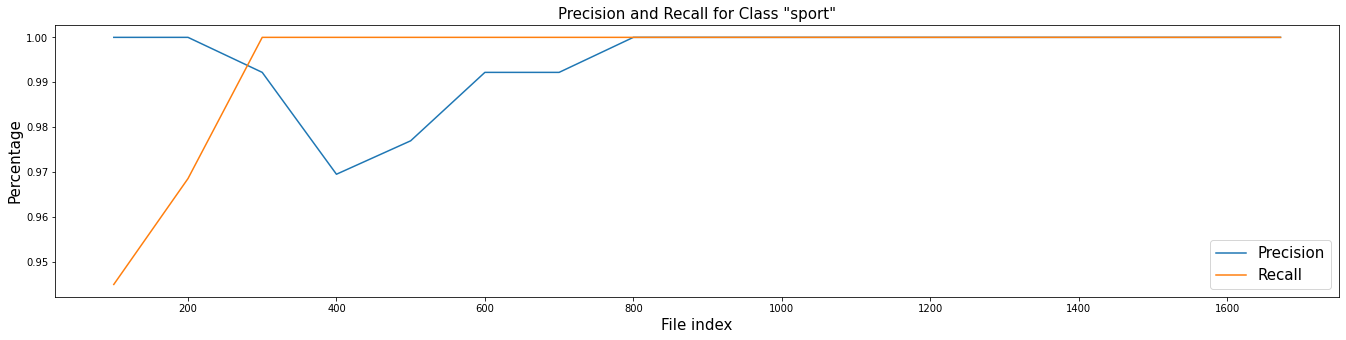

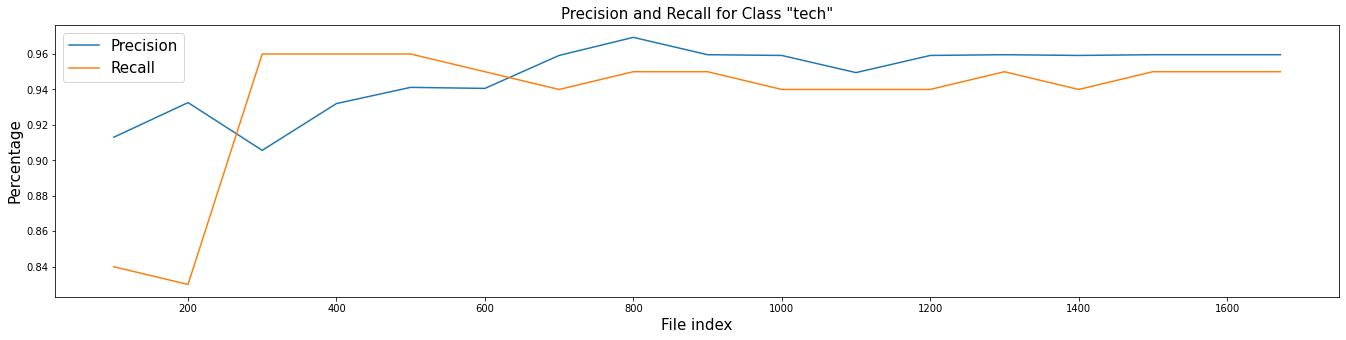


Testing classification: NO ELIMINATION + NO LEMMATISATION...


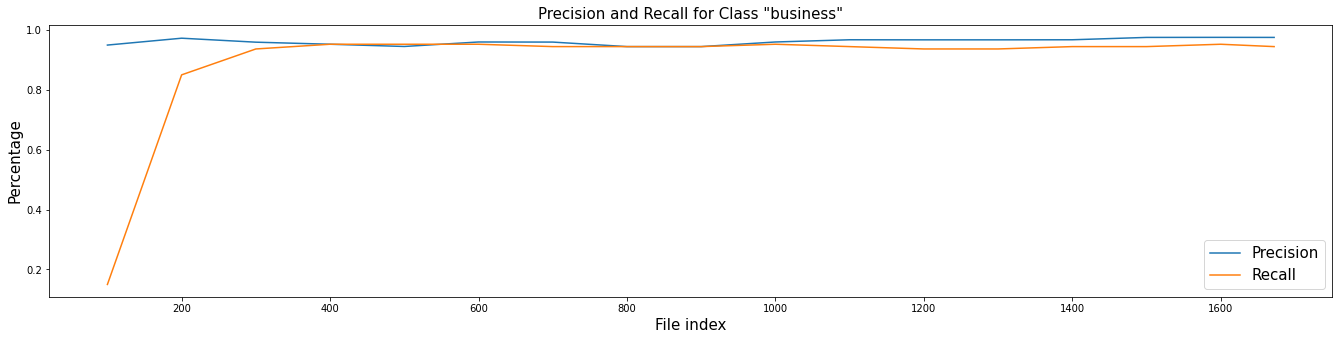

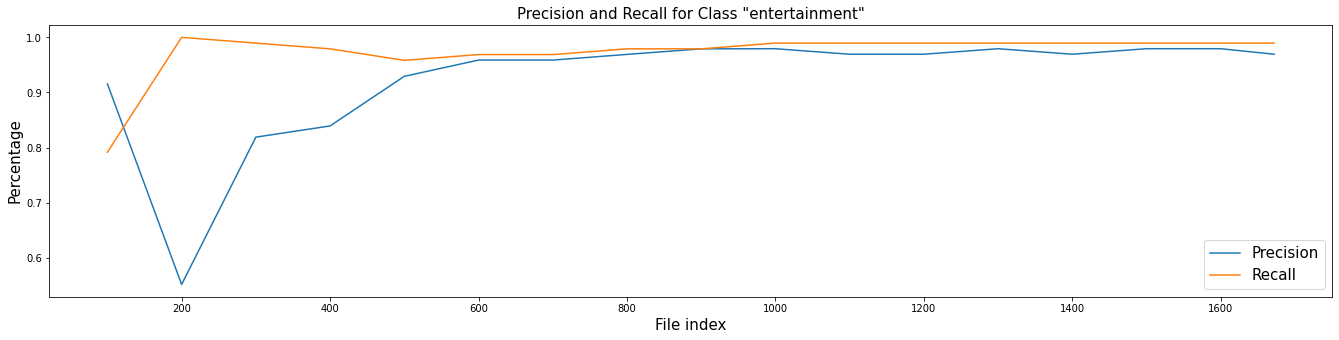

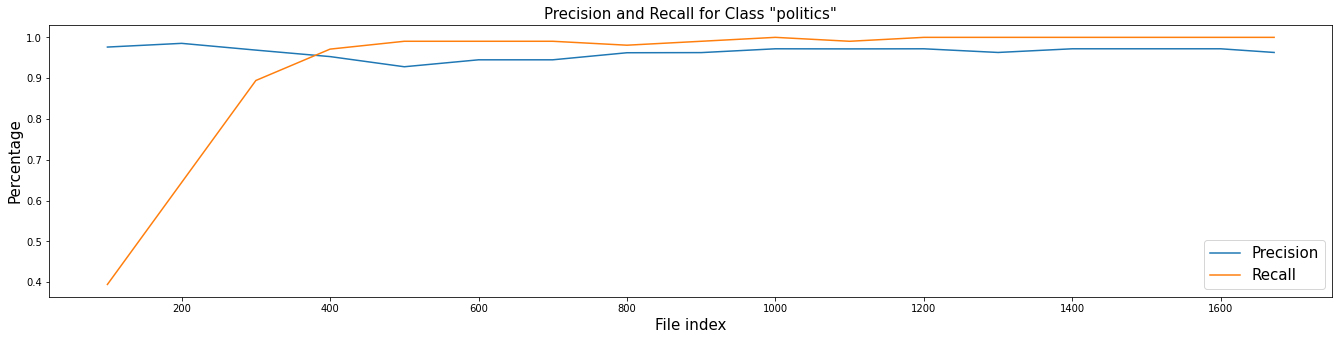

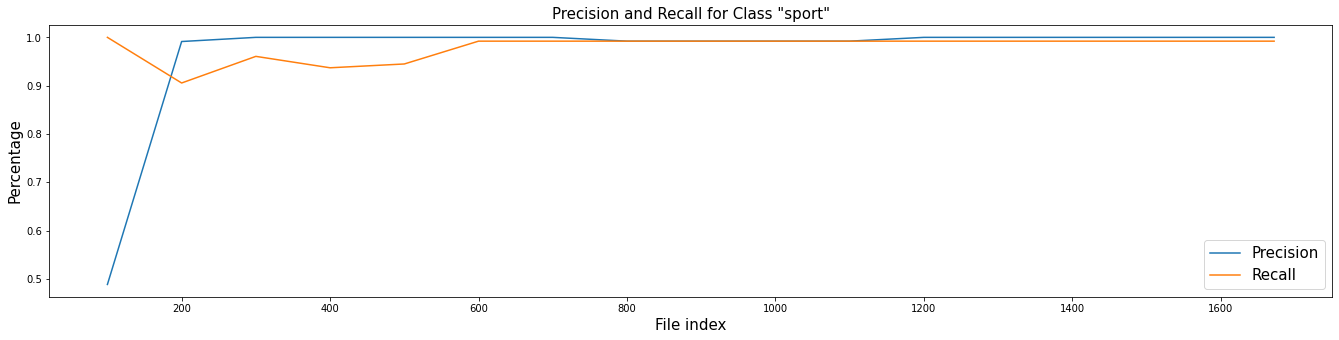

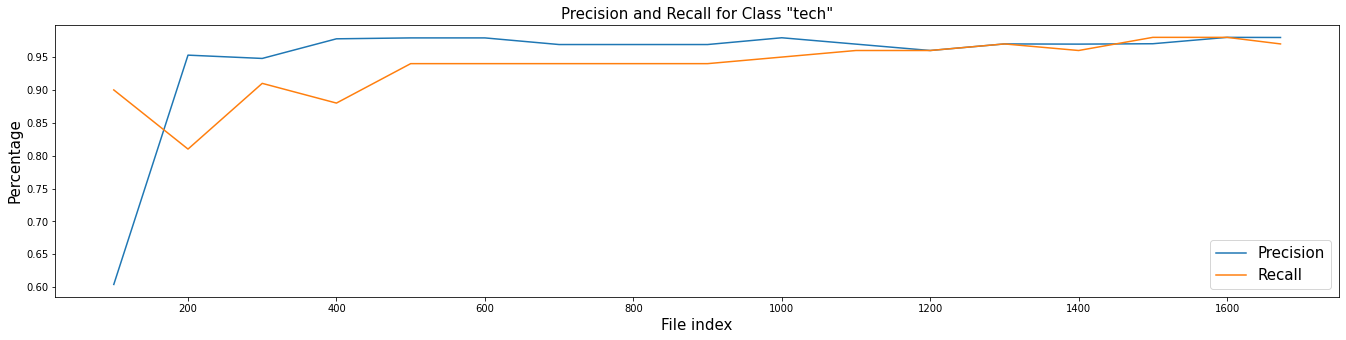

In [4]:
print("Testing classification: ELIMINATION + LEMMATISATION...")
train_and_test('BBC News Summary/News Articles', 'stop_words', True, True)
print("")

print("Testing classification: NO ELIMINATION + LEMMATISATION...")
train_and_test('BBC News Summary/News Articles', 'stop_words', False, True)
print("")

print("Testing classification: ELIMINATION + NO LEMMATISATION...")
train_and_test('BBC News Summary/News Articles', 'stop_words', True, False)
print("")

print("Testing classification: NO ELIMINATION + NO LEMMATISATION...")
train_and_test('BBC News Summary/News Articles', 'stop_words', False, False)
print("")


# Cele mai bune rezultate - Cerinta 2
```
Testing classification: ELIMINATION + LEMMATISATION...
====== business ======
Recall = 0.968503937007874
Precision = 0.9919354838709677

====== entertainment ======
Recall = 0.9791666666666666
Precision = 0.9591836734693877

====== politics ======
Recall = 0.9711538461538461
Precision = 0.9619047619047619

====== sport ======
Recall = 1.0
Precision = 1.0

====== tech ======
Recall = 0.98
Precision = 0.98


Testing classification: NO ELIMINATION + LEMMATISATION...
====== business ======
Recall = 0.968503937007874
Precision = 0.9761904761904762

====== entertainment ======
Recall = 0.9583333333333334
Precision = 0.989247311827957

====== politics ======
Recall = 0.9807692307692307
Precision = 0.9807692307692307

====== sport ======
Recall = 1.0
Precision = 1.0

====== tech ======
Recall = 0.98
Precision = 0.9423076923076923


Testing classification: ELIMINATION + NO LEMMATISATION...
====== business ======
Recall = 0.952755905511811
Precision = 0.983739837398374

====== entertainment ======
Recall = 0.9895833333333334
Precision = 0.9693877551020408

====== politics ======
Recall = 0.9711538461538461
Precision = 0.9711538461538461

====== sport ======
Recall = 0.9921259842519685
Precision = 1.0

====== tech ======
Recall = 0.99
Precision = 0.9611650485436893


Testing classification: NO ELIMINATION + NO LEMMATISATION...
====== business ======
Recall = 0.968503937007874
Precision = 0.984

====== entertainment ======
Recall = 0.9895833333333334
Precision = 0.979381443298969

====== politics ======
Recall = 0.9807692307692307
Precision = 0.9902912621359223

====== sport ======
Recall = 1.0
Precision = 1.0

====== tech ======
Recall = 0.98
Precision = 0.9607843137254902
```